<a href="https://colab.research.google.com/github/dizzySummer/An-Introduction-to-Statistical-Learning/blob/master/pseudo_multilateralism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fasttext
!pip install pycountry
!pip install transformers
!pip3 install transformers torch sentencepiece
!pip install gwpy &> /dev/null #hide all log message
!pip install gwpy --quiet

In [2]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import os
import time
import sys
from tqdm import tqdm
tqdm.pandas()
#import fasttext
import re
import nltk 
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
#tf.keras.backend.clear_session()
import itertools
import pycountry
import collections
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import HTML
from IPython.core import display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
text_list=[]
with open('/content/drive/MyDrive/CARBIS_BAY_G7_SUMMIT_COMMUNIQUÉ.txt') as f:
    text_list = f.read().split('.')
    # remove spaces
    text_list = [line.replace('  ', '') for line in text_list]
print(text_list)
#f.close()

['Our Shared Agenda for Global Action to Build Back Better\nWe, the leaders of the Group of Seven, met in Cornwall on 11-13 June 2021 determined to beat COVID-19 and build back better', ' We remembered everyone who has been lost to the pandemic and paid tribute to those still striving to overcome it', ' Inspired by their example of collaboration and determination, we gathered united by the principle that brought us together originally, that shared beliefs and shared responsibilities are the bedrock of leadership and prosperity', ' Guided by this, our enduring ideals as free open societies and democracies, and by our commitment to multilateralism, we have agreed a shared G7 agenda for global action to:\n● End the pandemic and prepare for the future by driving an intensified international effort, starting immediately, to vaccinate the world by getting as many safe vaccines to as many people as possible as fast as possible', ' Total G7 commitments since the start of the pandemic provide f

In [4]:
#total sentences
len(text_list)

514

In [5]:
#get all avaiable countries and regions list
couOrRegions=[]
for couOrRegion in pycountry.countries:
  couOrRegions.append(couOrRegion.name)
   

In [6]:
#match module country/region names with names mentioned in the report
for n, i in enumerate(couOrRegions):
  if i == 'Korea, Republic of':
    couOrRegions[n] = "Republic of Korea"
  if i == "Korea, Democratic people's republic of":
    couOrRegions[n] = "Democratic people's republic of Korea"
  if i=="Iran, Islamic republic of":
    couOrRegions[n] ="Iran"
  if i=="Russian Federation":
    couOrRegions[n]="Russia"
  if i=="Taiwan, Province of China":
    couOrRegions[n] ="Taiwan"


In [7]:
#add extra name list that do not exist in the module list
couOrRegions.extend(("Xinjiang","Tigray","Kurdish Peshmerga"))
#couOrRegions


In [8]:
#extract countries or regions mentioned in the summit
collects=[]

for sentence in text_list:
  for name in couOrRegions:
    if name in sentence:
      collects.append(name)

In [9]:
collects

['United Kingdom',
 'Australia',
 'India',
 'Republic of Korea',
 'South Africa',
 'Japan',
 'China',
 'Australia',
 'India',
 'Republic of Korea',
 'South Africa',
 'China',
 'China',
 'Hong Kong',
 'Xinjiang',
 'Russia',
 'Russia',
 'Russia',
 'Ukraine',
 'Russia',
 'Ukraine',
 'Russia',
 'Ukraine',
 'Russia',
 'Ukraine',
 'Belarus',
 'Belarus',
 'Ethiopia',
 'Tigray',
 'Tigray',
 'Eritrea',
 'Ethiopia',
 'Mali',
 'Chad',
 'Libya',
 'Libya',
 'Afghanistan',
 'Afghanistan',
 'Republic of Korea',
 'United States',
 'Myanmar',
 'Taiwan',
 'China',
 'United States',
 'Ukraine',
 'Iraq',
 'Kurdish Peshmerga',
 'Iraq',
 'Iraq',
 'Iraq']

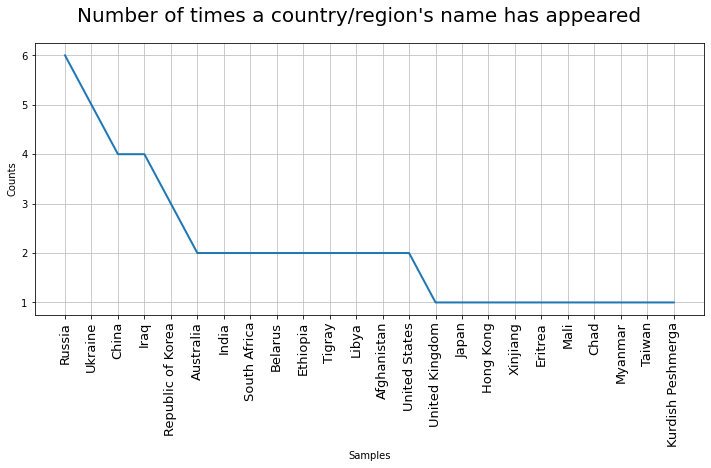

In [10]:
# plot name frequency mentioned in the report
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.suptitle("Number of times a country/region's name has appeared", fontsize=20)
fd = nltk.FreqDist(collects)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(collects).values(), reverse=True)


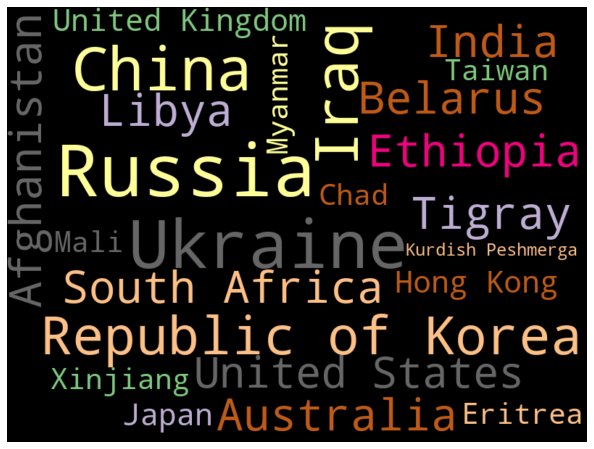

In [11]:
# create a word frequency dictionary
wordfreq = Counter(collects)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=800,
                      height=600,
                      max_words=25,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Accent_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
#select sentences that include country/region names
pick_text=[]

for sentence in text_list: 
  for names in collects:
   if names in sentence:
     pick_text.append(sentence)
     break

In [13]:
#convert those sentences to dataframe
df= pd.DataFrame(pick_text,columns=['text'])
#df

In [14]:
#build a column that contains country/region names mentioned in the report
df['name']=''
for name in collects:
  for i in range(len(df)):
    if name in df['text'][i]:
      if name not in df['name'][i]:
        df['name'][i]+=name+" "

In [15]:
df = df[['name','text']]
df = df.sort_values('name').reset_index(drop=True)
#df

In [16]:
def clean_text(text):
  text=re.sub('covid-19','COVID19',str(text))
  text=re.sub('act-a','ACTA',str(text))
  text=re.sub('[^A-Za-z0-9]+', ' ',str(text))
  text=re.sub(r'[^\w\s]',' ',text) #strip punctions (recheck)
  text=text.lower()
  return text

In [17]:
df['text']=df['text'].apply(clean_text)

In [18]:
#import transformer for analyzing sentiment and summarize sentences
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis")
summarization = pipeline("summarization")

In [19]:
#sentiment analysis
df['label']=''
df['confidence_score']=''
#df['summary_text']=''
for i in tqdm(range(len(df))):
  label=sentiment_analysis(df['text'][i])[0]
  df['label'][i]=label['label']
  df['confidence_score'][i]=label['score']


100%|██████████| 37/37 [00:02<00:00, 13.95it/s]


In [20]:
df['text'][9]#Positive? 

' at the same time and in so doing we will promote our values including by calling on china to respect human rights and fundamental freedoms especially in relation to xinjiang and those rights freedoms and high degree of autonomy for hong kong enshrined in the sino british joint declaration and the basic law'

In [21]:
df['text'][25] #???

' we reaffirm our call on russia to stop its destabilising behaviour and malign activities including its interference in other countries democratic systems and to fulfil its international human rights obligations and commitments'

In [23]:
df["summary_text"]=""
for i in range(len(df)):
  df["summary_text"][i]=summarization(df['text'][i])[0]['summary_text']  

Your max_length is set to 142, but you input_length is only 51. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 29. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 65. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 32. You might consider

In [24]:
df

,name,text,label,confidence_score,summary_text
0,Afghanistan,we are determined to maintain our support for...,POSITIVE,0.998718,We are determined to maintain our support for...
1,Afghanistan,in afghanistan a sustainable inclusive politi...,POSITIVE,0.993625,in afghanistan a sustainable inclusive politi...
2,Australia India Republic of Korea South Africa,we were joined in cornwall by the leaders of ...,POSITIVE,0.999404,"Leaders of Australia, South Africa and the Re..."
3,Australia India Republic of Korea South Africa,we will work together to promote our shared v...,POSITIVE,0.999495,We will work together to promote our shared v...
4,Belarus,we will work together to hold those responsib...,POSITIVE,0.998104,We will work together to hold those responsib...
5,Belarus,we are deeply concerned by the belarusian aut...,POSITIVE,0.929849,We are deeply concerned by the belarusian aut...
6,China,we remain seriously concerned about the situa...,POSITIVE,0.986745,"""We remain seriously concerned about the situ..."
7,China,we also call for a timely transparent expert ...,POSITIVE,0.996193,We also call for a timely transparent expert ...
8,China,with regard to china and competition in the g...,POSITIVE,0.851895,With regard to china and competition in the g...
9,China Hong Kong Xinjiang,at the same time and in so doing we will prom...,POSITIVE,0.999644,Britain calls on china to respect human right...


It seems that the summarization funciton proceeded opposite, generate more texts instead of shortening it. I did not set max length when running the function and that might be an explaination. Anyway, the result shows that Transformer is not a suitable tool for implmenting sentiment analysis for this kind of document.

In [25]:
df['text'][9]

' at the same time and in so doing we will promote our values including by calling on china to respect human rights and fundamental freedoms especially in relation to xinjiang and those rights freedoms and high degree of autonomy for hong kong enshrined in the sino british joint declaration and the basic law'

In [26]:
df['summary_text'][9] #what did Boris say?

' Britain calls on china to respect human rights and fundamental freedoms especially in relation to xinjiang and those rights freedoms and high degree of autonomy for hong kong enshrined in the sino british joint declaration and the basic law . at the same time and in so doing we will promote our values .'

In [27]:
df['text'][10]

' we call for an immediate cessation of hostilities unimpeded humanitarian access to all areas and the immediate withdrawal of 20 eritrean forces'

In [28]:
df['summary_text'][10]

' We call for an immediate cessation of hostilities unimpeded humanitarian access to all areas and the immediate withdrawal of 20 eritrean forces .  we call for the immediate cessation  of hostilities and the withdrawal of the 20 forces that have engaged in the conflict, we say.  We also call for a cease-fire and withdrawal of forces .'

In [29]:
#stop_list=['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his','through', 'don','me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘now’, ‘under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than','also'] 

In [30]:
#df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stop_list])